In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import itertools
from sklearn.preprocessing import MinMaxScaler

In [2]:
# importo i dataset
training_set = pd.read_csv("train.csv")
testing_set = pd.read_csv("test.csv")

In [3]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   15000 non-null  object 
 1   duration_ms            15000 non-null  int64  
 2   explicit               15000 non-null  bool   
 3   popularity             15000 non-null  int64  
 4   artists                15000 non-null  object 
 5   album_name             15000 non-null  object 
 6   danceability           15000 non-null  float64
 7   energy                 15000 non-null  float64
 8   key                    15000 non-null  int64  
 9   loudness               15000 non-null  float64
 10  mode                   10550 non-null  float64
 11  speechiness            15000 non-null  float64
 12  acousticness           15000 non-null  float64
 13  instrumentalness       15000 non-null  float64
 14  liveness               15000 non-null  float64
 15  va

Filling the missing values of the train set

In [4]:
# crea un df con due colonne genre e n. di missing values per ogni genre, ed aggiunge l'indice alle righe
missing_counts = training_set.groupby('genre')['mode'].apply(lambda x: x.isnull().sum()).reset_index()

# rinomino le colonne del df missing_counts, che orasi chiameranno genre e missing_count invece che genre e mode
missing_counts.columns = ['genre', 'missing_count']

# Crea il DataFrame df1 privo di missing values
df1 = training_set[training_set['mode'].notnull()]

# Calcola le frequenze di 0 e 1 per ciascun genere in df1
# frequencies_by_genre è un df che contiene le frequenze di 0 e 1 per ciascun genere
frequencies_by_genre = df1.groupby('genre')['mode'].value_counts(normalize=True).unstack().fillna(0)

# Sostituisci i missing values con liste di 0 e 1 basate sulle frequenze per ogni genere
for genre in training_set['genre'].unique():
    # restituisce True se c'è un missing value in mode e se è il genere in questione
    missing_values = training_set['mode'].isnull() & (training_set['genre'] == genre)
    # seleziona la giusta riga e colonna del df missing_counts e restituisce il conteggio di missing values per quel genre
    missing_count = missing_counts[missing_counts['genre'] == genre]['missing_count'].values[0]

    if missing_count > 0:
        # retituisce la coppia di frequenze per i valori 0 e 1 per il genre in questione
        frequencies = frequencies_by_genre.loc[genre]
        # crea un array di 0 e 1 estratti in base alle frequenze del genere, utilizzate come probabilità
        replacement_values = np.random.choice([0, 1], size=missing_count, p=frequencies)
        # sostituisce i missing values (True) della colonna mode con i valori dell'array precedente
        training_set.loc[missing_values, 'mode'] = replacement_values

In [5]:
training_set['time_signature'] = training_set['time_signature'].fillna(training_set['time_signature'].mode()[0])

In [6]:
training_set = training_set.drop(['time_signature','mode','key','processing','n_bars', 'explicit', 'features_duration_ms', 'popularity_confidence', 'name', 'artists', 'album_name', 'genre'], axis = 1)

The regression is performed only on numerical features

In [18]:
training_set.head()

,duration_ms,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,n_beats
0,241760,46,0.690,0.513,-12.529,0.0975,0.302000,0.53600,0.281,0.6350,142.221,567.0
1,444000,0,0.069,0.196,-24.801,0.0805,0.283000,0.93400,0.360,0.0336,75.596,617.0
2,333506,3,0.363,0.854,-7.445,0.0397,0.000089,0.80000,0.262,0.4890,116.628,652.0
3,269800,23,0.523,0.585,-5.607,0.0765,0.066400,0.00127,0.117,0.3850,140.880,619.0
4,307651,25,0.643,0.687,-11.340,0.0539,0.000576,0.09690,0.299,0.6370,143.956,733.0


In [31]:
numerical_columns = training_set.select_dtypes(include=['float64', 'int64']).columns

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max scaling to all numerical columns
training_set[numerical_columns] = scaler.fit_transform(training_set[numerical_columns])

In [32]:
training_set.head()

,duration_ms,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,n_beats
0,0.056710,0.489362,0.704082,0.513,0.702298,0.103834,0.303213,0.53600,0.282696,0.638191,0.644920,0.077164
1,0.105897,0.000000,0.070408,0.196,0.469376,0.085729,0.284137,0.93400,0.362173,0.033769,0.342800,0.083968
2,0.079024,0.031915,0.370408,0.854,0.798793,0.042279,0.000090,0.80000,0.263581,0.491457,0.528865,0.088732
3,0.063530,0.244681,0.533673,0.585,0.833678,0.081470,0.066667,0.00127,0.117706,0.386935,0.638839,0.084241
4,0.072736,0.265957,0.656122,0.687,0.724866,0.057401,0.000578,0.09690,0.300805,0.640201,0.652788,0.099755


In [33]:
df_train, df_test = train_test_split(training_set, test_size=0.3, random_state=100)

# Simple Regression

In [9]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In regression tasks we want to see how much a feature (x) can influence the behaviour of another feature (y), so we proceeded to do some connections between the variables that makes sense to explore the possibilities.
Our first try aims to measure how danceability of a song can affect its popularity.

In [34]:
# Initialize an empty DataFrame to store results
result_df = pd.DataFrame(columns=['Target', 'Independent Var', 'R2', 'SSE', 'MSE'])

# List of columns in the DataFrame
all_columns = training_set.columns

# Iterate over all possible combinations of independent and dependent variables
for dependent_var in all_columns:
    independent_vars = [col for col in all_columns if col != dependent_var]

    for independent_var in itertools.combinations(independent_vars, 1):
        # Create a new row in the result DataFrame
        result_df = result_df.append({'Target': dependent_var, 'Independent Var': independent_var[0]}, ignore_index=True)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(training_set[list(independent_var)], training_set[dependent_var], test_size=0.2, random_state=42)

        # Fit a linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        r2 = r2_score(y_test, y_pred)
        sse = sum((y_test - y_pred) ** 2)
        mse = mean_squared_error(y_test, y_pred)

        # Update the last row of the result DataFrame with model evaluation metrics
        result_df.loc[result_df.index[-1], ['R2', 'SSE', 'MSE']] = [r2, sse, mse]

result_df = result_df.sort_values(by='R2', ascending=False)

C:\Users\matti\AppData\Local\Temp\ipykernel_18992\3753403371.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Target': dependent_var, 'Independent Var': independent_var[0]}, ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_18992\3753403371.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Target': dependent_var, 'Independent Var': independent_var[0]}, ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_18992\3753403371.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Target': dependent_var, 'Independent Var': independent_var[0]}, ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_18992

C:\Users\matti\AppData\Local\Temp\ipykernel_18992\3753403371.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Target': dependent_var, 'Independent Var': independent_var[0]}, ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_18992\3753403371.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Target': dependent_var, 'Independent Var': independent_var[0]}, ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_18992\3753403371.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Target': dependent_var, 'Independent Var': independent_var[0]}, ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_18992

C:\Users\matti\AppData\Local\Temp\ipykernel_18992\3753403371.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Target': dependent_var, 'Independent Var': independent_var[0]}, ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_18992\3753403371.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Target': dependent_var, 'Independent Var': independent_var[0]}, ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_18992\3753403371.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Target': dependent_var, 'Independent Var': independent_var[0]}, ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_18992

C:\Users\matti\AppData\Local\Temp\ipykernel_18992\3753403371.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Target': dependent_var, 'Independent Var': independent_var[0]}, ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_18992\3753403371.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Target': dependent_var, 'Independent Var': independent_var[0]}, ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_18992\3753403371.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Target': dependent_var, 'Independent Var': independent_var[0]}, ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_18992

C:\Users\matti\AppData\Local\Temp\ipykernel_18992\3753403371.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Target': dependent_var, 'Independent Var': independent_var[0]}, ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_18992\3753403371.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Target': dependent_var, 'Independent Var': independent_var[0]}, ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_18992\3753403371.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Target': dependent_var, 'Independent Var': independent_var[0]}, ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_18992

In [38]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
result_df

,Target,Independent Var,R2,SSE,MSE
10,duration_ms,n_beats,0.784715,0.564556,0.000188
121,n_beats,duration_ms,0.770774,1.02515,0.000342
47,loudness,energy,0.511859,18.910314,0.006303
36,energy,loudness,0.511363,100.51113,0.033504
69,acousticness,energy,0.479471,170.226507,0.056742
38,energy,acousticness,0.478866,107.195785,0.035732
70,acousticness,loudness,0.299556,229.063567,0.076355
49,loudness,acousticness,0.299512,27.136499,0.009045
101,valence,danceability,0.290236,164.797752,0.054933
30,danceability,valence,0.290093,83.083027,0.027694


In [67]:
x_train = df_train["energy"].values.reshape(-1, 1)
y_train = df_train["loudness"].values

x_test = df_test["energy"].values.reshape(-1, 1)
y_test = df_test["loudness"].values

In [ ]:
#x_train = df_train["duration_ms"].values.reshape(-1, 1)
#y_train = df_train["n_beats"].values

#x_test = df_test["duration_ms"].values.reshape(-1, 1)
#y_test = df_test["n_beats"].values

# Lasso

In [72]:
from sklearn.linear_model import Lasso, LassoCV

lasso = Lasso(max_iter = 10000)
coef = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    coef.append(lasso.coef_)

np.shape(coef)

C:\Users\matti\anaconda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\matti\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\matti\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.304e+01, tolerance: 1.385e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_d

(100, 1)

In [73]:
lasso_cv=LassoCV(alphas=range(0,100))
lasso_cv.fit(x_train, y_train)

lasso_cv.alpha_

C:\Users\matti\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\matti\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\matti\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\matti\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did no

0

In [74]:
reg_lasso = Lasso(alpha= 0.01)
reg_lasso.fit(x_train, y_train)
print('Coefficients: \n', reg_lasso.coef_)
print('Intercept: \n', reg_lasso.intercept_)
pd.DataFrame(reg_lasso.coef_)

Coefficients: 
 [0.17108181]
Intercept: 
 0.658372261647399


,0
0,0.171082


In [75]:
y_pred=reg_lasso.predict(x_test)

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.414
MSE: 0.007
MAE: 0.058


# Ridge

In [68]:
from sklearn.linear_model import RidgeCV

#initialize list to store coefficient values
coefs = []
alphas = range(0,100)

for a in alphas:
    ridge=Ridge(alpha=a)
    ridge.fit(x_train, y_train)
    coefs.append(ridge.coef_)

np.shape(coefs)

(100, 1)

In [69]:
reg_cv=RidgeCV(alphas=range(1,100))
reg_cv.fit(x_train, y_train)

reg_cv.alpha_

1

In [70]:
reg_ridge = Ridge(alpha= reg_cv.alpha_)
reg_ridge.fit(x_train, y_train)
print('Coefficients: \n', reg_ridge.coef_)
print('Intercept: \n', reg_ridge.intercept_)

Coefficients: 
 [0.31338228]
Intercept: 
 0.5652089733484819


In [71]:
y_pred=reg_ridge.predict(x_test)

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.511
MSE: 0.006
MAE: 0.053


## Linear

In [55]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

In [43]:
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [0.97758753]
Intercept: 
 0.011572343154712228


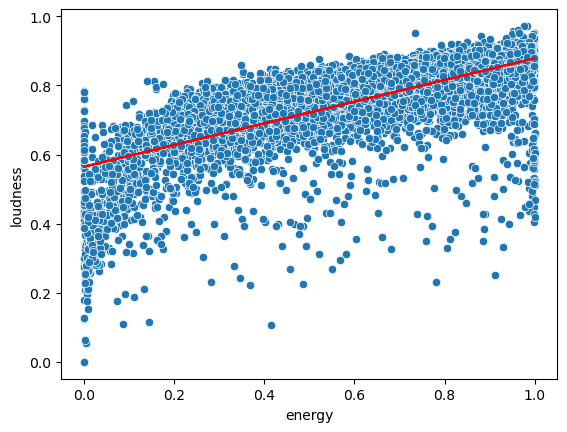

In [57]:
sns.scatterplot(data=df_train, x="energy", y="loudness")
plt.plot(x_train, reg.coef_[0]*x_train+reg.intercept_, c="red")


In [58]:
y_pred = reg.predict(x_test)

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.511
MSE: 0.006
MAE: 0.053


R2 value of 0.003 indicates that the model explains a very small percentage of the variance in the target variable, that suggests that the model does not fit the data well.

In [22]:
x_train = df_train["loudness"].values.reshape(-1, 1)
y_train = df_train["energy"].values

x_test = df_test["loudness"].values.reshape(-1, 1)
y_test = df_test["energy"].values

In [23]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

In [24]:
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [0.03163264]
Intercept: 
 0.9375553634820175


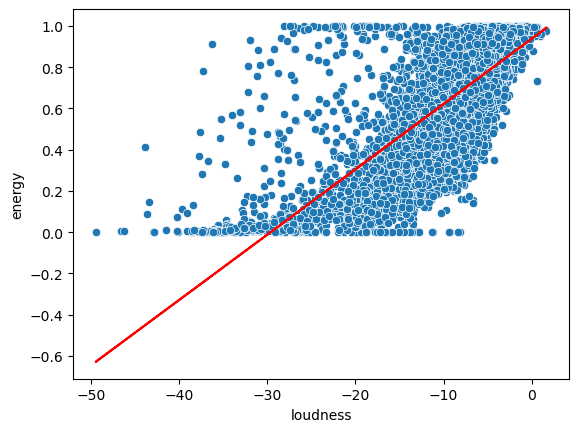

In [25]:
sns.scatterplot(data=df_train, x="loudness", y="energy")
plt.plot(x_train, reg.coef_[0]*x_train+reg.intercept_, c="red")

In [26]:
y_pred = reg.predict(x_test)

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.512
MSE: 0.034
MAE: 0.145


In this second try we observe a much better value of R2, we see that loudness can explain more than 50% of energy variance

In [27]:
x_train = df_train["tempo"].values.reshape(-1, 1)
y_train = df_train["danceability"].values

x_test = df_test["tempo"].values.reshape(-1, 1)
y_test = df_test["danceability"].values

In [28]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

In [29]:
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [0.00054093]
Intercept: 
 0.4848025212486253


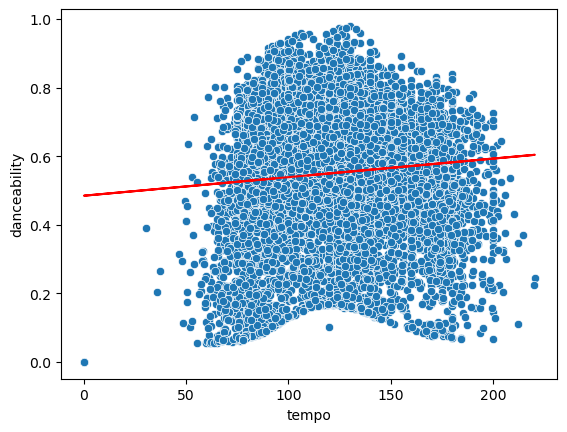

In [30]:
sns.scatterplot(data=df_train, x="tempo", y="danceability")
plt.plot(x_train, reg.coef_[0]*x_train+reg.intercept_, c="red")

In [31]:
y_pred = reg.predict(x_test)

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.010
MSE: 0.038
MAE: 0.157


In the last experiment we explore the relationship between danceability (how suitable a song is for dancing) and tempo (the speed of a song). Faster tempos might be associated with higher danceability. The results tell us that the relation we've supposed is not identifiable in this particular case.

In [57]:
# Y(popularity) = X(danceability) R2: 0.003 | MSE: 342.767 | MAE: 15.461
# Y(energy) = X(loudness) R2: 0.512 | MSE: 0.034 | MAE: 0.145
# Y(danceability) = X(tempo) R2: 0.010 | MSE: 0.038 | MAE: 0.157

## Non-linear

### Decision Tree

In [76]:
from sklearn.tree import DecisionTreeRegressor

In [77]:
reg = DecisionTreeRegressor()

In [ ]:
x_train = df_train["danceability"].values.reshape(-1, 1)
y_train = df_train["popularity"].values

x_test = df_test["danceability"].values.reshape(-1, 1)
y_test = df_test["popularity"].values

In [78]:
reg.fit(x_train, y_train)

DecisionTreeRegressor()

In [79]:
y_pred = reg.predict(x_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.572
MSE: 0.005
MAE: 0.050


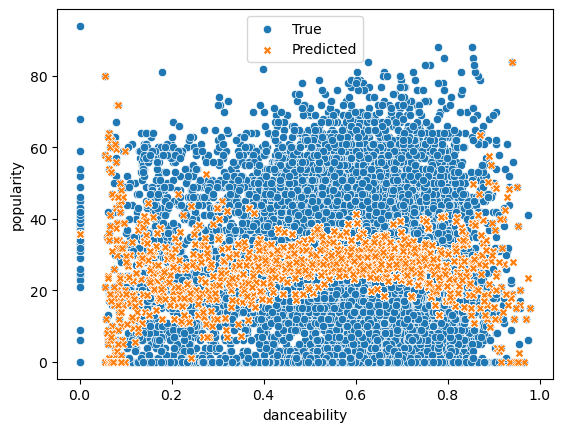

In [38]:
# Non so quanto effettivamente abbia senso considerare/commentare questo 
# grafico, dato che siamo in tema di regressione e non di classificazione/previsione
sns.scatterplot(data=df_train, x="danceability", y="popularity", label="True")
sns.scatterplot(data=df_train, x="danceability", y=reg.predict(x_train), label="Predicted", marker="X")
plt.legend()
plt.show()

The negative r2 value tells us that the model choosen is not ideal to fit the data we've got, it also is a signal that popularity has too much variability and the model is not able to extract any useful information about the relation between these features

In [48]:
x_train = df_train["loudness"].values.reshape(-1, 1)
y_train = df_train["energy"].values

x_test = df_test["loudness"].values.reshape(-1, 1)
y_test = df_test["energy"].values

In [49]:
reg.fit(x_train, y_train)

DecisionTreeRegressor()

In [50]:
y_pred = reg.predict(x_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.231
MSE: 0.053
MAE: 0.169


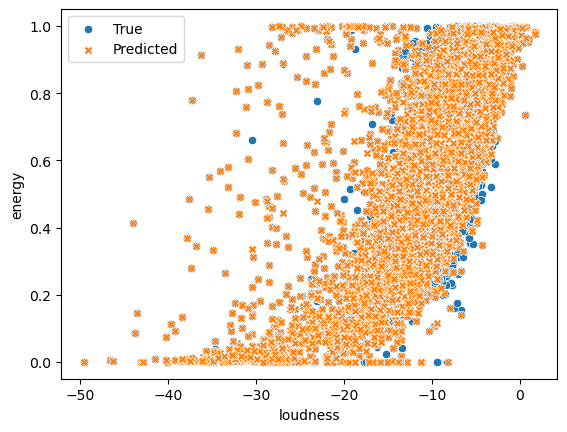

In [51]:
# Non so quanto effettivamente abbia senso considerare/commentare questo 
# grafico, dato che siamo in tema di regressione e non di classificazione/previsione
sns.scatterplot(data=df_train, x="loudness", y="energy", label="True")
sns.scatterplot(data=df_train, x="loudness", y=reg.predict(x_train), label="Predicted", marker="X")
plt.legend()
plt.show()

In [52]:
x_train = df_train["tempo"].values.reshape(-1, 1)
y_train = df_train["danceability"].values

x_test = df_test["tempo"].values.reshape(-1, 1)
y_test = df_test["danceability"].values

In [53]:
reg.fit(x_train, y_train)

DecisionTreeRegressor()

In [54]:
y_pred = reg.predict(x_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: -0.300
MSE: 0.049
MAE: 0.172


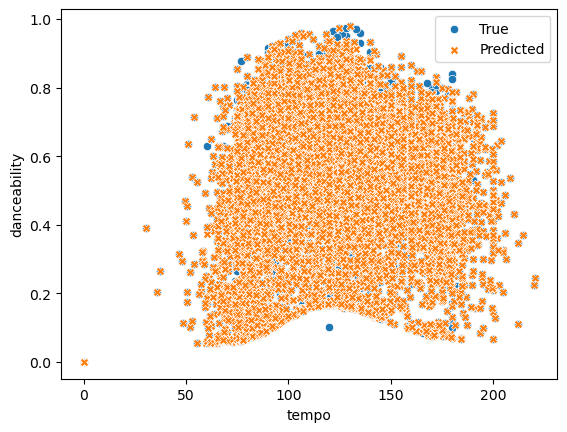

In [55]:
# Non so quanto effettivamente abbia senso considerare/commentare questo 
# grafico, dato che siamo in tema di regressione e non di classificazione/previsione
sns.scatterplot(data=df_train, x="tempo", y="danceability", label="True")
sns.scatterplot(data=df_train, x="tempo", y=reg.predict(x_train), label="Predicted", marker="X")
plt.legend()
plt.show()

In [56]:
# Y(popularity) = X(danceability) R2: -0.103 | MSE: 379.184 | MAE: 15.993
# Y(energy) = X(loudness) R2: 0.231 | MSE: 0.053 | MAE: 0.169
# Y(danceability) = X(tempo) R2: -0.300 | MSE: 0.049 | MAE: 0.172

## KNN

In [80]:
from sklearn.neighbors import KNeighborsRegressor

In [81]:
reg = KNeighborsRegressor()

In [60]:
x_train = df_train["danceability"].values.reshape(-1, 1)
y_train = df_train["popularity"].values

x_test = df_test["danceability"].values.reshape(-1, 1)
y_test = df_test["popularity"].values

In [82]:
reg.fit(x_train, y_train)

KNeighborsRegressor()

In [83]:
y_pred = reg.predict(x_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.560
MSE: 0.006
MAE: 0.051


In [63]:
x_train = df_train["loudness"].values.reshape(-1, 1)
y_train = df_train["energy"].values

x_test = df_test["loudness"].values.reshape(-1, 1)
y_test = df_test["energy"].values

In [64]:
reg.fit(x_train, y_train)

KNeighborsRegressor()

In [65]:
y_pred = reg.predict(x_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.492
MSE: 0.035
MAE: 0.143


In [66]:
x_train = df_train["tempo"].values.reshape(-1, 1)
y_train = df_train["danceability"].values

x_test = df_test["tempo"].values.reshape(-1, 1)
y_test = df_test["danceability"].values

In [67]:
reg.fit(x_train, y_train)

KNeighborsRegressor()

In [68]:
y_pred = reg.predict(x_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.153
MSE: 0.032
MAE: 0.142


In [69]:
# Y(popularity) = X(danceability) R2: -0.208 | MSE: 415.384 | MAE: 16.778
# Y(energy) = X(loudness) R2: 0.492 | MSE: 0.035 | MAE: 0.143
# Y(danceability) = X(tempo) R2: 0.153 | MSE: 0.032 | MAE: 0.142

# Multiple Regression

Multiple regression differs from the single because even if it involves only one dependant variable (y) it requires more than one independent variable (x), we're now exploring these possibilities 

In [ ]:
# energy = loudness, danceability, tempo 
# R2: 0.532
# MSE: 0.033
# MAE: 0.140

In [ ]:
# energy = loudness, danceability, tempo, liveness
# R2: 0.556
# MSE: 0.031
# MAE: 0.138

In [ ]:
# danceability = energy, loudness, tempo, valence
# R2: -0.092
# MSE: 0.076
# MAE: 0.227

In [ ]:
# popularity = danceability, energy, loudness, speechiness, acousticness, 
# instrumentalness, valence, tempo
# R2: 0.103
# MSE: 308.494
# MAE: 14.493

We will explore three different ways to test multiple regression, in the first we're gonna use 3 independent variables, then we will increase the amount to see if the model is capable to explain much of the variance

## Linear

In [70]:
# energy = loudness, danceability, tempo
X_train = df_train[["loudness", "danceability", "tempo"]].values
y_train = df_train["energy"].values

X_test = df_test[["loudness", "danceability", "tempo"]].values
y_test = df_test["energy"].values

In [71]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [72]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.532
MSE: 0.033
MAE: 0.140


Now we try to add a feature that we think could be important in the "energy" explanation to observe how much r2 changes

In [79]:
# energy = loudness, danceability, tempo, liveness
X_train = df_train[["loudness", "danceability", "tempo", "liveness"]].values
y_train = df_train["energy"].values

X_test = df_test[["loudness", "danceability", "tempo","liveness"]].values
y_test = df_test["energy"].values

In [80]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [81]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.556
MSE: 0.031
MAE: 0.138


From the increasing of the x we got a +0.034 in the r2 value, we expected an higher value as the liveness in a recorded track could be very powerful and give more energy to a song compared to the studio version. But for us it is still enough to prefer this model to the previous

In [73]:
# danceability = energy, loudness, tempo, valence
X_train = df_train[["loudness", "energy", "tempo", "valence"]].values
y_train = df_train["danceability"].values

X_test = df_test[["loudness", "energy", "tempo", "valence"]].values
y_test = df_test["energy"].values

In [74]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [75]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: -0.092
MSE: 0.076
MAE: 0.227


In [76]:
# popularity = loudness, danceability, tempo, energy, speechiness, acousticness, 
# instrumentalness, valence
X_train = df_train[["loudness", "danceability", "tempo","energy","speechiness","acousticness","instrumentalness","valence"]].values
y_train = df_train["popularity"].values

X_test = df_test[["loudness", "danceability", "tempo","energy","speechiness","acousticness","instrumentalness","valence"]].values
y_test = df_test["popularity"].values

In [77]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [78]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.103
MSE: 308.494
MAE: 14.493


# Non-linear

## Decision Trees

In [82]:
reg = DecisionTreeRegressor()

In [86]:
# energy = loudness, danceability, tempo, liveness
X_train = df_train[["loudness", "danceability", "tempo", "liveness"]].values
y_train = df_train["energy"].values

X_test = df_test[["loudness", "danceability", "tempo","liveness"]].values
y_test = df_test["energy"].values

In [87]:
reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [88]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.341
MSE: 0.046
MAE: 0.157


In [89]:
# danceability = energy, loudness, tempo, valence
X_train = df_train[["loudness", "energy", "tempo", "valence"]].values
y_train = df_train["danceability"].values

X_test = df_test[["loudness", "energy", "tempo", "valence"]].values
y_test = df_test["energy"].values

In [90]:
reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [91]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: -0.448
MSE: 0.101
MAE: 0.253


In [92]:
# popularity = loudness, danceability, tempo, energy, speechiness, acousticness, 
# instrumentalness, valence
X_train = df_train[["loudness", "danceability", "tempo","energy","speechiness","acousticness","instrumentalness","valence"]].values
y_train = df_train["popularity"].values

X_test = df_test[["loudness", "danceability", "tempo","energy","speechiness","acousticness","instrumentalness","valence"]].values
y_test = df_test["popularity"].values

In [93]:
reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [94]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: -0.592
MSE: 547.360
MAE: 17.963


In [ ]:
# energy = loudness, danceability, tempo, liveness
# R2: 0.341
# MSE: 0.046
# MAE: 0.157

# danceability = energy, loudness, tempo, valence
# R2: -0.448
# MSE: 0.101
# MAE: 0.253

# popularity = danceability, energy, loudness, speechiness, acousticness, 
# instrumentalness, valence, tempo
# R2: -0.592
# MSE: 547.360
# MAE: 17.963

## Ridge/Lasso

Ridge and Lasso regression are powerful techniques generally used for creating parsimonious models in the presence of a ‘large’ number of features. They are used to prevent overfitting in regression models by adding regularization terms to the cost function, encouraging simpler models with fewer predictors and more generalizability.

Ridge regression Performs L2 regularization, i.e., adds penalty equivalent to the square of the magnitude of coefficients. ridge regression optimizes the following => Objective = RSS + α * (sum of the square of coefficients)
Here, α (alpha) is the parameter that balances the amount of emphasis given to minimizing RSS vs minimizing the sum of squares of coefficients. α can take various values: α = 0 simple linear regression | α = ∞ coefficients will be zero.

Lasso regression is a regularization technique. It is used over regression methods for a more accurate prediction. This model uses shrinkage. Shrinkage is where data values are shrunk towards a central point as the mean: it performs L1 regularization, i.e., adds penalty equivalent to the absolute value of the magnitude of coefficients. Lasso regression optimizes the following => Objective = RSS + α * (sum of the absolute value of coefficients), α = 0: Same coefficients as simple linear regression | α = ∞: All coefficients zero (same logic as before).

We use Ridge when we have many correlated predictors and want to avoid multicollinearity. Use Lasso when feature selection is crucial or when we want a sparse model.

In [123]:
# it's often a good idea to normalize the data before using these two techniques
from sklearn import preprocessing
df_train_scaled = preprocessing.scale(training_set)
df_train_scaled=pd.DataFrame(df_train_scaled, columns = training_set.columns)

In [124]:
df_train, df_test = train_test_split(df_train_scaled, test_size=0.3, random_state=100)

# Ridge

In [125]:
# energy = loudness, danceability, tempo, liveness
x_train = df_train[["duration_ms", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "n_beats", "processing"]].values
y_train = df_train["popularity"].values

x_test = df_test[["duration_ms", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "n_beats", "processing"]].values
y_test = df_test["popularity"].values

In [126]:
#initialize list to store coefficient values
coefs = []
alphas = range(0,100)

for a in alphas:
    ridge=Ridge(alpha=a)
    ridge.fit(x_train, y_train)
    coefs.append(ridge.coef_)

np.shape(coefs)

(100, 12)

(-4.95, 103.95, -0.3123737529117371, 0.0564330703279719)

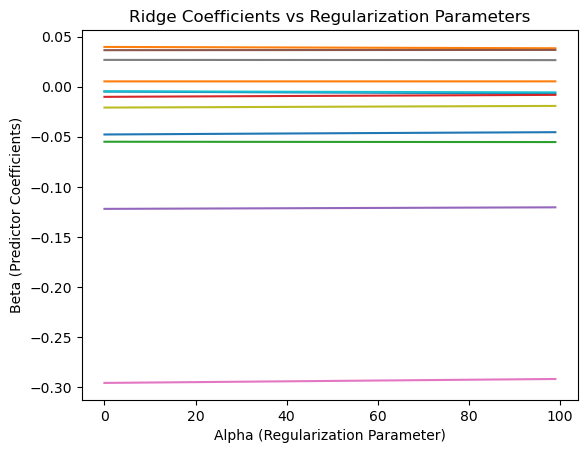

In [127]:
# Make plot of Beta as a function of Alpha
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(alphas,coefs)
ax.set_xlabel('Alpha (Regularization Parameter)')
ax.set_ylabel('Beta (Predictor Coefficients)')
ax.set_title('Ridge Coefficients vs Regularization Parameters')
ax.axis('tight')

As alpha increases, the coefficients tend to stabilize and converge towards zero. This means that the predictors become less influential in the model as the regularization becomes stronger.
The predictors with the highest absolute coefficients are x1 and x2, which indicate that they are the most important predictors in the model. They also have the most variation in their coefficients as alpha changes.

To select the optimal value of alpha we use the cross validation

In [128]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

reg_cv=RidgeCV(alphas=range(1,100))
reg_cv.fit(x_train, y_train)

reg_cv.alpha_

99

In [129]:
reg_ridge = Ridge(alpha= reg_cv.alpha_)
reg_ridge.fit(x_train, y_train)
print('Coefficients: \n', reg_ridge.coef_)
print('Intercept: \n', reg_ridge.intercept_)

Coefficients: 
 [-0.00670107  0.03833078 -0.05526115 -0.00817612 -0.12039458  0.03668626
 -0.29168767  0.02650282 -0.01920932 -0.00570064 -0.04541593  0.00529986]
Intercept: 
 0.0044343186666930875


In [130]:
y_pred=reg_ridge.predict(x_test)

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.106
MSE: 0.890
MAE: 0.777


# Lasso

In [131]:
from sklearn.linear_model import Lasso, LassoCV

lasso = Lasso(max_iter = 10000)
coef = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    coef.append(lasso.coef_)

np.shape(coef)

C:\Users\matti\anaconda\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\matti\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\matti\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.729e+03, tolerance: 1.052e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_d

(100, 12)

In [132]:
lasso_cv=LassoCV(alphas=range(0,100))
lasso_cv.fit(x_train, y_train)

lasso_cv.alpha_

C:\Users\matti\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\matti\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3780.336372035484, tolerance: 0.8406728280035939
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\matti\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\matti\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objec

0

The optimal alpha that was obtained from it is 0. This means no regularization is needed and it's just a linear regressor. That result shows that we are not overfitting.

In [133]:
#"0:duration_ms", "1:danceability", "2:energy", 
#"3:loudness", "4:speechiness", "5:acousticness",
#"6:instrumentalness", "7:liveness", "8:valence", "9:tempo",
#"10:n_beats", "11:processing"

reg_lasso = Lasso(alpha= 0.01)
reg_lasso.fit(x_train, y_train)
print('Coefficients: \n', reg_lasso.coef_)
print('Intercept: \n', reg_lasso.intercept_)
pd.DataFrame(reg_lasso.coef_)

Coefficients: 
 [-0.          0.01212648 -0.05583504 -0.         -0.10884791  0.02960824
 -0.27871465  0.01254184 -0.         -0.         -0.04708518  0.        ]
Intercept: 
 0.0046645087068621725


,0
0,-0.000000
1,0.012126
2,-0.055835
3,-0.000000
4,-0.108848
5,0.029608
6,-0.278715
7,0.012542
8,-0.000000
9,-0.000000


Lasso technique is used to do a feature selection among the ones that are in the df. From our cross validation method we obtained that the optimal value was alpha = 0, which means that all the features are contributing to the model and there's no need for regularization.

So we tried to test a very little value for alpha to observe if something would change, and we obtained that with alpha=0.01, 5 features became meaningless in the model -> duration_ms, loudness, valence, tempo and processing

# KNN

In [ ]:
# energy = loudness, danceability, tempo, liveness
# R2: 0.940
# MSE: 0.004
# MAE: 0.047
    /-/
# danceability = energy, loudness, tempo, valence
# R2: -0.342
# MSE: 0.093
# MAE: 0.244
    /-/
# popularity = loudness, danceability, tempo, energy, speechiness, acousticness
# instrumentalness, valence
# R2: 0.089
# MSE: 313.308
# MAE: 14.065

In [142]:
df_train, df_test = train_test_split(training_set, test_size=0.3, random_state=100)

In [143]:
reg_knn = KNeighborsRegressor()

In [144]:
# energy = loudness, danceability, tempo, liveness
X_train = df_train[["loudness", "danceability", "tempo", "liveness"]].values
y_train = df_train["energy"].values

X_test = df_test[["loudness", "danceability", "tempo","liveness"]].values
y_test = df_test["energy"].values

In [148]:
reg_knn.fit(x_train, y_train)

KNeighborsRegressor()

In [146]:
y_pred_knn = reg_knn.predict(x_test)
print('R2: %.3f' % r2_score(y_test, y_pred_knn))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred_knn))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred_knn))

R2: 0.940
MSE: 0.004
MAE: 0.047


In [147]:
# danceability = energy, loudness, tempo, valence
X_train = df_train[["loudness", "energy", "tempo", "valence"]].values
y_train = df_train["danceability"].values

X_test = df_test[["loudness", "energy", "tempo", "valence"]].values
y_test = df_test["energy"].values

In [149]:
reg_knn.fit(x_train, y_train)

KNeighborsRegressor()

In [150]:
y_pred_knn = reg_knn.predict(x_test)
print('R2: %.3f' % r2_score(y_test, y_pred_knn))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred_knn))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred_knn))

R2: -0.342
MSE: 0.093
MAE: 0.244


In [151]:
# popularity = loudness, danceability, tempo, energy, speechiness, acousticness, 
# instrumentalness, valence
X_train = df_train[["loudness", "danceability", "tempo","energy","speechiness","acousticness","instrumentalness","valence"]].values
y_train = df_train["popularity"].values

X_test = df_test[["loudness", "danceability", "tempo","energy","speechiness","acousticness","instrumentalness","valence"]].values
y_test = df_test["popularity"].values

In [152]:
reg_knn.fit(x_train, y_train)

KNeighborsRegressor()

In [153]:
y_pred_knn = reg_knn.predict(x_test)
print('R2: %.3f' % r2_score(y_test, y_pred_knn))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred_knn))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred_knn))

R2: 0.089
MSE: 313.308
MAE: 14.065


# Multivariate Regression

In [158]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   duration_ms       15000 non-null  int64  
 1   popularity        15000 non-null  int64  
 2   danceability      15000 non-null  float64
 3   energy            15000 non-null  float64
 4   key               15000 non-null  int64  
 5   loudness          15000 non-null  float64
 6   mode              15000 non-null  float64
 7   speechiness       15000 non-null  float64
 8   acousticness      15000 non-null  float64
 9   instrumentalness  15000 non-null  float64
 10  liveness          15000 non-null  float64
 11  valence           15000 non-null  float64
 12  tempo             15000 non-null  float64
 13  time_signature    15000 non-null  float64
 14  n_beats           15000 non-null  float64
 15  processing        15000 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 1

In [160]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load data into a pandas DataFrame
# Assuming df is your DataFrame
# Replace 'your_data.csv' with your actual data file or use the appropriate method for loading your data
# df = pd.read_csv('your_data.csv')

# Assuming df is your DataFrame
# If your data is not in the specified format, adjust accordingly
feature_columns = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 
                    'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
                    'valence', 'tempo', 'time_signature', 'n_beats', 'processing']

# Generate all possible combinations of two features as target and three features as variables
target_combinations = list(combinations(feature_columns, 2))
variable_combinations = list(combinations(feature_columns, 3))
results_list = []

# Loop over target combinations
for target_combination in target_combinations:
    target = training_set[list(target_combination)]
    
    # Loop over variable combinations
    for variable_combination in variable_combinations:
        # Check if target and variables do not overlap
        if not any(feature in variable_combination for feature in target_combination):
            # Extract variables
            variables = training_set[list(variable_combination)]
            
            # Split the data into X (variables) and y (target)
            X_train, X_test, y_train, y_test = train_test_split(variables, target, test_size=0.2, random_state=42)
            
            # Fit multivariate regression
            regression_model = LinearRegression()
            regression_model.fit(X_train, y_train)
            
            # Predict the target values
            y_pred = regression_model.predict(X_test)
            
            # Evaluate performance using metrics
            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            
            # Store results in a dictionary
            result_dict = {'Target': target_combination, 'Variables': variable_combination, 'R2': r2, 'MSE': mse, 'MAE': mae}
            results_list.append(result_dict)

# Convert the list of dictionaries into a pandas DataFrame
results_df = pd.DataFrame(results_list)

# Display or save the result (you can adjust the filename and format accordingly)
print(results_df)

                            Target                                  Variables  \
0      (duration_ms, danceability)                    (energy, key, loudness)   
1      (duration_ms, danceability)                        (energy, key, mode)   
2      (duration_ms, danceability)                 (energy, key, speechiness)   
3      (duration_ms, danceability)                (energy, key, acousticness)   
4      (duration_ms, danceability)            (energy, key, instrumentalness)   
...                            ...                                        ...   
30025        (n_beats, processing)  (instrumentalness, tempo, time_signature)   
30026        (n_beats, processing)                 (liveness, valence, tempo)   
30027        (n_beats, processing)        (liveness, valence, time_signature)   
30028        (n_beats, processing)          (liveness, tempo, time_signature)   
30029        (n_beats, processing)           (valence, tempo, time_signature)   

             R2           M

In [174]:
max_r2_rows = results_df.groupby('Target')['R2'].idxmax()

# Extract the rows with maximum R2 for each target combination
max_r2_results = results_df.loc[max_r2_rows]

# Print the results
best_df = pd.DataFrame(max_r2_results)
pd.set_option('display.max_rows', None)
best_df.sort_values(by='R2', ascending=False, inplace=True)
best_df

,Target,Variables,R2,MSE,MAE
10609,"(energy, n_beats)","(duration_ms, loudness, tempo)",0.729591,2.972049e+03,19.527248
447,"(duration_ms, energy)","(loudness, tempo, n_beats)",0.728798,5.665751e+08,7922.856746
16606,"(loudness, n_beats)","(duration_ms, energy, tempo)",0.721058,2.980742e+03,21.084913
974,"(duration_ms, loudness)","(energy, tempo, n_beats)",0.719786,5.671074e+08,7957.093788
23470,"(acousticness, n_beats)","(duration_ms, energy, tempo)",0.711896,2.972094e+03,19.770957
1832,"(duration_ms, acousticness)","(energy, tempo, n_beats)",0.710929,5.671074e+08,7955.782774
27750,"(valence, n_beats)","(duration_ms, danceability, tempo)",0.621307,2.981093e+03,19.476499
2635,"(duration_ms, valence)","(danceability, tempo, n_beats)",0.620698,5.655559e+08,7931.578740
7210,"(danceability, n_beats)","(duration_ms, valence, tempo)",0.607658,2.988095e+03,19.422085
277,"(duration_ms, danceability)","(valence, tempo, n_beats)",0.606551,5.664231e+08,7918.222982


In multivariate regression, we decided that was optimal to build a function that tells us which combinations of target-variables was performing best with linear regression so we can focus our analysis to the better-performing ones. It's noticeable that all of the first three elements of the ranking involved the same features, so we limit our analysis to the first one.

In [175]:
X_train = df_train[["loudness", "duration_ms","tempo"]].values
y_train = df_train[["energy", "n_beats"]].values

X_test = df_test[["loudness", "duration_ms","tempo"]].values
y_test = df_test[["energy", "n_beats"]].values

## Decision Tree

In [176]:
reg = DecisionTreeRegressor()

In [177]:
reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [178]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.423
MSE: 1272.203
MAE: 10.245


## KNN

In [179]:
reg_knn = KNeighborsRegressor()

In [180]:
reg_knn.fit(X_train, y_train)

KNeighborsRegressor()

In [181]:
y_pred = reg_knn.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.375
MSE: 7997.150
MAE: 42.909


# Ridge

# Lasso